In [22]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import tqdm

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, Imputer, OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelBinarizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_union, make_pipeline

### 1. Базовый разведочный анализ данных

In [2]:
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")
df_store = pd.read_csv("store.csv")

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_train['Date'] = df_train['Date'].astype('datetime64[ns]')
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Набор данных train содержит следующую информацию:
- Store - id магазина;
- DayOfWeek - день недели;
- Date - дата;
- Sales - количество проданных товаров (оборот магазина в рассматриваемый день. Это величина, которую надо предсказать);
- Customers - количество покупателей в рассматриваемый день;
- Open - индикатор того, был ли магазин открыт (0 - закрыт; 1 - открыт);
- Promo - индикатор того, была ли в магазине промо-акция (?) в рассматриваемый день;
- StateHoliday - индикатор того, был ли в этот день выходной. Возможные значения: a - обычный выходной; b - Пасха; с - Рождество; 0 - не выходной день;
- SchoolHoliday - указывает, были ли закрыты школы в этот день (?)

In [4]:
df_test['Date'] = df_test['Date'].astype('datetime64[ns]')
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


Тут всё тоже замое, но количество продаж неизвестно

In [5]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Дополнительные характеристики магазинов:
- StoreType - 4 различных возможных модели магазина: a, b, c, d;
- Assortment - описывает уровень ассортимента: a - основной, b - дополнительный; c - расширенный;
- CompetitionDistance - расстояние в метрах до ближайшего конкурирующего магазина;
- CompetitionOpenSinceMonth, CompetitionOpenSinceYear - показывает примерный год и месяц, когда открылся ближайших конкурирующий магазин;
- Promo2 - Promo2 это непрерывная и последовательная рекламная акция для некоторых магазинов: 0 - магазин не участвует; 1 - магазин участвует;
- Promo2SinceWeek, Promo2SinceYear - описывает год и неделю, когда магазин начал участвовать в Promo2;
- PromoInterval - описываются последовательные интервал Promo2, названия месяцев, когда акция начинается заново. Например Feb, May, Aug, Nov означает, что каждый "раунд" начинается в феврале, мае, августе, ноябре

In [6]:
df_train_sales = df_train[df_train['Sales'] != 0]

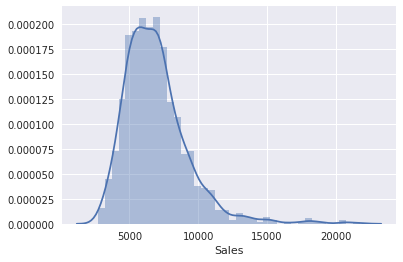

In [7]:
# Средние продажи в магазинах по дням, когда продажи были > 0
sns.distplot(df_train_sales.groupby(['Store']).mean()['Sales'])

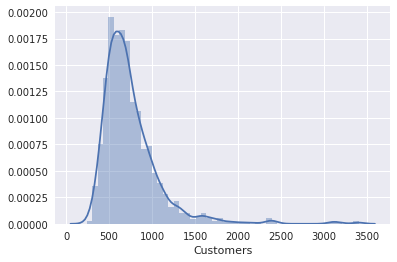

In [8]:
# Среднее количество покупателей в магазинах
sns.distplot(df_train_sales.groupby(['Store']).mean()['Customers'])

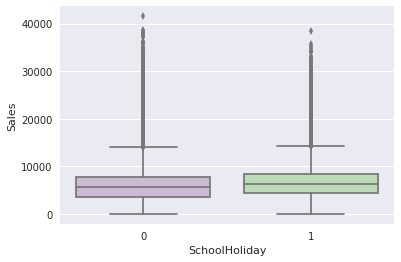

In [9]:
# Влияет ли работа школ на продажи?
sns.boxplot(x=df_train['SchoolHoliday'], y=df_train['Sales'], palette="PRGn")
# Пожалуй, некоторое смещение наблюдается, но едва уловимое

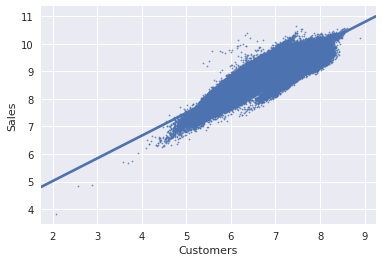

In [10]:
# Как связано количество продаж и количество покупателей?
df1 = df_train_sales[df_train_sales['Customers'] != 0]
x = np.log(df1['Customers'])
y = np.log(df1['Sales'])
sns.regplot(x, y, scatter_kws={'s':3}, fit_reg=True)

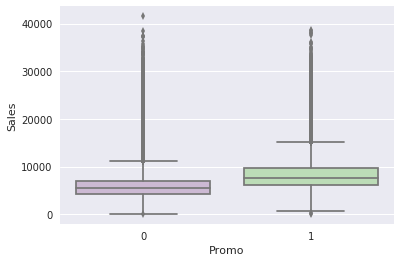

In [11]:
# Зависимость продаж от промо-акции
sns.boxplot(x=df1['Promo'], y=df1['Sales'], palette="PRGn")
# Здесь зависимость достаточно заметна

In [12]:
# Среднее количество продаж на одного покупателя
df2_no_promo = df_train_sales[df_train_sales['Promo'] == 0]
df2_promo = df_train_sales[df_train_sales['Promo'] == 1]
print(np.mean(df2_no_promo['Sales'] / df2_no_promo['Customers']))
print(np.mean(df2_promo['Sales'] / df2_promo['Customers']))

8.941127696725117
10.178960909582786


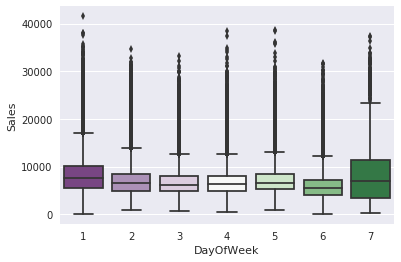

In [13]:
# Продажи в зависимости от дня недели
sns.boxplot(x=df1['DayOfWeek'], y=df1['Sales'], palette="PRGn")
# В пятницу, воскресенье и понедельник продажи повышаются

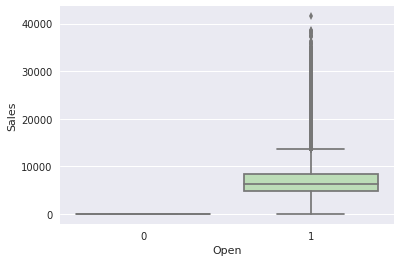

In [20]:
# Продажи в зависимости от того, открыт ли магазин
sns.boxplot(x=df_train['Open'], y=df_train['Sales'], palette="PRGn")

In [14]:
df_train_store = pd.merge(df_train, df_store, on='Store')
df_train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


### 2. Построить простую модель и реализовать подбор параметров и кросс-валидацию для данных с учётом наличия времени в данных

Так как у нас множество временных рядов, а не один, то будем использовать модели на признаках

In [46]:
len(df_train_store)

1017209

Посчитаем продажи за предыдущий день и разницу в продажах за предыдущий день и день перед ним

In [47]:
df_train_store_2 = df_train_store.copy()
df_train_store_2 = df_train_store_2.sort_values(['Date'])

In [48]:
df_train_store_2['LastDaySales'] = df_train_store_2.groupby(['Store'])['Sales'].shift()
df_train_store_2[df_train_store_2['Store'] == 500]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,LastDaySales
456279,500,2,2013-01-01,0,0,0,0,a,1,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",NaN
456278,500,3,2013-01-02,3663,283,1,0,0,1,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",0.0
456277,500,4,2013-01-03,3531,290,1,0,0,1,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",3663.0
456276,500,5,2013-01-04,4229,332,1,0,0,1,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",3531.0
456275,500,6,2013-01-05,3871,303,1,0,0,0,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",4229.0
456274,500,7,2013-01-06,0,0,0,0,a,0,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",3871.0
456273,500,1,2013-01-07,5463,425,1,1,0,0,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",0.0
456272,500,2,2013-01-08,4346,294,1,1,0,0,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",5463.0
456271,500,3,2013-01-09,3878,297,1,1,0,0,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",4346.0
456270,500,4,2013-01-10,3499,260,1,1,0,0,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",3878.0


In [49]:
df_train_store_2['LastDayDiff'] = df_train_store_2.groupby(['Store'])['LastDaySales'].diff()
df_train_store_2[df_train_store_2['Store'] == 500]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,LastDaySales,LastDayDiff
456279,500,2,2013-01-01,0,0,0,0,a,1,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",NaN,NaN
456278,500,3,2013-01-02,3663,283,1,0,0,1,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",0.0,NaN
456277,500,4,2013-01-03,3531,290,1,0,0,1,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",3663.0,3663.0
456276,500,5,2013-01-04,4229,332,1,0,0,1,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",3531.0,-132.0
456275,500,6,2013-01-05,3871,303,1,0,0,0,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",4229.0,698.0
456274,500,7,2013-01-06,0,0,0,0,a,0,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",3871.0,-358.0
456273,500,1,2013-01-07,5463,425,1,1,0,0,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",0.0,-3871.0
456272,500,2,2013-01-08,4346,294,1,1,0,0,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",5463.0,5463.0
456271,500,3,2013-01-09,3878,297,1,1,0,0,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",4346.0,-1117.0
456270,500,4,2013-01-10,3499,260,1,1,0,0,d,c,10690.0,9.0,2007.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",3878.0,-468.0


In [23]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

### Baseline
В качестве простейшего наивного предсказания возьмём продажи за предыдущий день

In [50]:
date_min = df_train_store_2['Date'].min()
date_max = df_train_store_2['Date'].max()

In [51]:
# Средняя ошибка по всем магазинам в определённый день
mean_error = []

for day in pd.date_range(start=date_min + pd.DateOffset(2), end=date_max):
    val = df_train_store_2[df_train_store_2['Date'] == day]
    p = val['LastDaySales'].values
    error = rmsle(val['Sales'].values, p)
    mean_error.append(error)
    
print(min(mean_error))
print(max(mean_error))
print(sum(mean_error)/len(mean_error))

0.07307533699923388
9.421191308469721
3.0091172654482032


In [57]:
# Преобразуем признаки в числовые, чтобы с ними могли работать модели
df_train_store_2.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,LastDaySales,LastDayDiff
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",NaN,NaN
679363,746,2,2013-01-01,0,0,0,0,a,1,d,c,4330.0,2.0,2011.0,1,35.0,2011.0,"Mar,Jun,Sept,Dec",NaN,NaN
155193,171,2,2013-01-01,0,0,0,0,a,1,a,a,2640.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
632403,694,2,2013-01-01,0,0,0,0,a,1,a,c,460.0,11.0,2012.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",NaN,NaN
361623,396,2,2013-01-01,0,0,0,0,a,1,a,c,23130.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


In [ ]:
class LabelEncoderPipelineFriendly(LabelEncoder):
    
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelEncoderPipelineFriendly, self).fit(X)
        
    def transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).transform(X).reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).fit(X).transform(X).reshape(-1, 1)

In [ ]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [ ]:
def get_pclass_col(df):
    return df[['Pclass']]

def get_sex_col(df):
    return df[['Sex']]

def get_age_col(df):
    return df[['Age']]

def get_num_cols(df):
    return df[['Age', 'SibSp', 'Parch', 'Fare']]

def get_sum_cols(df):
    return df[['SibSp', 'Parch']]

def get_div_cols(df):
    return df[['Parch', 'Age']]

def get_embarked_col(df):
    return df[['Embarked']]

# с использованием StandardScaler
vec_standard = make_union(*[
    make_pipeline(FunctionTransformer(get_pclass_col, validate=False),  OneHotEncoder(sparse=False)),
    make_pipeline(FunctionTransformer(get_sex_col, validate=False),  LabelEncoderPipelineFriendly()),
    make_pipeline(FunctionTransformer(get_num_cols, validate=False), Imputer(strategy='mean'), StandardScaler()),
    make_pipeline(FunctionTransformer(get_sum_cols, validate=False), Imputer(strategy='mean'), FeaturesSum(),
                  StandardScaler()),
    make_pipeline(FunctionTransformer(get_div_cols, validate=False), Imputer(strategy='mean'), FeaturesDivide(),
                  StandardScaler()),
    make_pipeline(FunctionTransformer(get_embarked_col, validate=False), DataFrameImputer(),
                  LabelEncoderPipelineFriendly(), OneHotEncoder(sparse=False))
])

# с использованием MinMaxScaler
vec_minmax = make_union(*[
    make_pipeline(FunctionTransformer(get_pclass_col, validate=False),  OneHotEncoder(sparse=False)),
    make_pipeline(FunctionTransformer(get_sex_col, validate=False),  LabelEncoderPipelineFriendly()),
    make_pipeline(FunctionTransformer(get_num_cols, validate=False), Imputer(strategy='mean'), MinMaxScaler()),
    make_pipeline(FunctionTransformer(get_sum_cols, validate=False), Imputer(strategy='mean'), FeaturesSum(),
                  MinMaxScaler()),
    make_pipeline(FunctionTransformer(get_div_cols, validate=False), Imputer(strategy='mean'), FeaturesDivide(),
                  MinMaxScaler()),
    make_pipeline(FunctionTransformer(get_embarked_col, validate=False), DataFrameImputer(),
                  LabelEncoderPipelineFriendly(), OneHotEncoder(sparse=False))
])

In [ ]:
x_train_standard = vec_standard.fit_transform(df_train)
x_train_minmax = vec_minmax.fit_transform(df_train)

x_train_standard.shape

In [ ]:
# Случайный лес (который учитывает основные признаки)
mean_error = []

for day in pd.date_range(start=date_min + pd.DateOffset(2), end=date_max):
    train = df_train_store_2[df_train_store_2['Date'] < day]
    val = df_train_store_2[df_train_store_2['Date'] == day]

    xtr, xts = train.drop(['Sales', ], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    mean_error.append(error)
    
print(min(mean_error))
print(max(mean_error))
print(sum(mean_error)/len(mean_error))

In [55]:
xtrain = df_train_store_2.drop(['Sales'], axis=1)
xtrain

,Store,DayOfWeek,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,LastDaySales,LastDayDiff
1017208,1115,2,2013-01-01,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",NaN,NaN
679363,746,2,2013-01-01,0,0,0,a,1,d,c,4330.0,2.0,2011.0,1,35.0,2011.0,"Mar,Jun,Sept,Dec",NaN,NaN
155193,171,2,2013-01-01,0,0,0,a,1,a,a,2640.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
632403,694,2,2013-01-01,0,0,0,a,1,a,c,460.0,11.0,2012.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",NaN,NaN
361623,396,2,2013-01-01,0,0,0,a,1,a,c,23130.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
177271,196,2,2013-01-01,0,0,0,a,1,c,a,3850.0,11.0,2005.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",NaN,NaN
246633,271,2,2013-01-01,0,0,0,a,1,a,a,420.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct",NaN,NaN
29407,32,2,2013-01-01,0,0,0,a,1,a,a,2910.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov",NaN,NaN
401231,440,2,2013-01-01,0,0,0,a,1,d,a,3900.0,4.0,2005.0,1,45.0,2009.0,"Feb,May,Aug,Nov",NaN,NaN
994762,1090,2,2013-01-01,0,0,0,a,1,a,a,330.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct",NaN,NaN
